In [1]:
import numpy as np
import mosek
import cvxpy as cp
import casadi as ca
from scipy.linalg import hankel
import matplotlib.pyplot as plt

In [2]:
def disc_linear_system(A, B, delta_t):
    '''
    Discrete a linear system with implicit Euler
    x[k+1] = (I - delta_t * A)^{-1} @ x[k] + (I - delta_t * A)^{-1} @ (delta_t * B) @ u[k]
    Returns:
        Ak
        Bk
    '''
    Nx = np.shape(A)[0]
    Ix = np.identity(Nx)

    Ak = np.linalg.inv(Ix - delta_t * A)
    Bk = np.linalg.inv(Ix - delta_t * A) @ (delta_t * B)

    
    def disc_linear_fn(x, u):
        x_next = Ak @ x + Bk @ u
        
        return x_next
    
    
    return disc_linear_fn

In [3]:
# def inverted_pendulum_ode(x, u):
#     M  = 1.096
#     m = 0.109
#     l = 0.25
#     b = 0.1
#     g = 9.81
#     I = 0.0034

#     p = I * (M + m) + M * m * l ** 2

#     A = np.array([[0, 1, 0, 0],
#                   [0, -(I+m*l**2)*b/p,  (m**2*g*l**2)/p,   0],
#                   [0, 0, 0, 1],
#                   [0, -(m*l*b)/p,       m*g*l*(M+m)/p,  0]])
#     B = np.array([[0], [(I+m*l**2)/p], [0], [m*l/p]])

#     dot_x = A @ x + B @ u

#     return dot_x

In [4]:
# Collect data as initial condition
def data_generation(sys, n, m, T, state_init = None, input_seq = None):
    # T is the length of collected data
    # Modify this for measurement functions (y = Cx)
    if input_seq is None:
        input_seq = np.random.rand(m, T) *10
    N_it = np.shape(input_seq)[1] # Number of iteration
    if state_init is None:
        state_init = np.random.rand(n,1) *10
    state_seq = state_init
    xk = state_init
    for _ in range(N_it):
        uk = input_seq[:,_].reshape(-1,m)
        state_next = sys(xk, uk)
        state_seq = np.append(state_seq, state_next,axis=1)
        xk = state_next
    # Remark: the length of state_seq is larger than the input_seq by one.
    return state_seq, input_seq

In [5]:
# Construct Hankel matrix
def Hankel(sequence, L):
    n, T = np.shape(sequence)
    print(n,T)
    Hankel_matrix = np.empty((n * L, 0), dtype = float)
    for _ in range(T-L+1):
        Hankel_matrix = np.append(Hankel_matrix, sequence[: , _ : _+L ].reshape(-1,1, order = 'F'),axis = 1)
    return Hankel_matrix
        

In [6]:
# Split matrix in to two part
def Hankel_split(Hankel_matrix, n, T_ini):
    # n is is the dim of the state (or input, output), T_ini stand for the length of the first part
    Hankel_p = Hankel_matrix[:T_ini * n,:] # "past"
    Hankel_f = Hankel_matrix[T_ini * n:,:] # "future"
    return Hankel_p, Hankel_f

In [7]:
# # Formulate optimization problem
# def define_opt(nu, ny, Q, R, r, U_Hankel, Y_Hankel, u_ini, y_ini, T, T_ini, N, uub = None, ulb = None, yub = None, ylb = None):
#     # Let the reference traj r be a set point here. To be modified, if tracking traj required.
    
#     u_decision = cp.Variable((N*nu,1))
#     y_decision = cp.Variable((N*ny,1))
    
#     L = T_ini + N
    
#     g = cp.Variable((T-L+1,1))
    
#     # Split matrices
#     Up, Uf = Hankel_split(U_Hankel,nu, T_ini)
#     Yp, Yf = Hankel_split(Y_Hankel,ny, T_ini)
    
#     loss_func = 0
#     for _ in range(N):
# #         loss_func += (y_decision[_ * ny : ( _ + 1 ) * ny ,:] - r).T @ Q @ (y_decision[_ * ny : ( _ + 1 ) * ny ,:] - r)
#         loss_func += cp.quad_form(y_decision[_ * ny : ( _ + 1 ) * ny ,:] - r, Q)
#         loss_func += cp.quad_form(u_decision[_ * nu : ( _ + 1 ) * nu ,:], R)
# #         loss_func += (y_decision[_ * ny : ( _ + 1 ) * ny ,:] ).T  @ (y_decision[_ * ny : ( _ + 1 ) * ny ,:])
# #         loss_func += (u_decision[_ * nu : ( _ + 1 ) * nu ,:]).T  @ (u_decision[_ * nu : ( _ + 1 ) * nu ,:])

#     obj = cp.Minimize(loss_func)
#     # Define constraints
#     constraint = []
    
#     constraint += [ Up @ g == u_ini ]
#     constraint += [ Yp @ g == y_ini ]
#     constraint += [ Uf @ g == u_decision ]
#     constraint += [ Yf @ g == y_decision ]
    
#     if uub is not None:
#         for _ in range(N):
#             constraint += [u_decision[_ * nu : ( _ + 1 ) * nu ,:] <= uub]
    
#     if ulb is not None:
#         for _ in range(N):
#             constraint += [u_decision[_ * nu : ( _ + 1 ) * nu ,:] >= ulb]

#     if yub is not None:
#         for _ in range(N):
#             constraint += [y_decision[_ * ny : ( _ + 1 ) * ny ,:] <= yub]
            
#     if ylb is not None:
#         for _ in range(N):
#             constraint += [y_decision[_ * ny : ( _ + 1 ) * ny ,:] >= ylb]
            
#     prob = cp.Problem(obj,constraint)
    
#     return prob, g

In [8]:
# Formulate optimization problem
def define_opt(nu, ny, Q, R, r, U_Hankel, Y_Hankel, T, T_ini, N, uub = None, ulb = None, yub = None, ylb = None):
    # Let the reference traj r be a set point here. To be modified, if tracking traj required.
    
    u_decision = cp.Variable((N*nu,1))
    y_decision = cp.Variable((N*ny,1))
    
    L = T_ini + N
    
    g = cp.Variable((T-L+1,1))
    
    u_ini_para = cp.Parameter((T_ini * nu, 1))
    y_ini_para = cp.Parameter((T_ini * ny, 1))
    
    # Split matrices
    Up, Uf = Hankel_split(U_Hankel, nu, T_ini)
    Yp, Yf = Hankel_split(Y_Hankel, ny, T_ini)
    
    loss_func = 0
    for _ in range(N):
#         loss_func += (y_decision[_ * ny : ( _ + 1 ) * ny ,:] - r).T @ Q @ (y_decision[_ * ny : ( _ + 1 ) * ny ,:] - r)
        loss_func += cp.quad_form(y_decision[_ * ny : ( _ + 1 ) * ny ,:] - r, Q)
        loss_func += cp.quad_form(u_decision[_ * nu : ( _ + 1 ) * nu ,:], R)

    obj = cp.Minimize(loss_func)
    # Define constraints
    constraint = []
    
    constraint += [ Up @ g == u_ini_para ]
    constraint += [ Yp @ g == y_ini_para ]
    constraint += [ Uf @ g == u_decision ]
    constraint += [ Yf @ g == y_decision ]
    
    if uub is not None:
        for _ in range(N):
            constraint += [u_decision[_ * nu : ( _ + 1 ) * nu ,:] <= uub]
    
    if ulb is not None:
        for _ in range(N):
            constraint += [u_decision[_ * nu : ( _ + 1 ) * nu ,:] >= ulb]

    if yub is not None:
        for _ in range(N):
            constraint += [y_decision[_ * ny : ( _ + 1 ) * ny ,:] <= yub]
            
    if ylb is not None:
        for _ in range(N):
            constraint += [y_decision[_ * ny : ( _ + 1 ) * ny ,:] >= ylb]
            
    prob = cp.Problem(obj,constraint)
    
    return prob, g, u_ini_para, y_ini_para

In [9]:
# Simulation
def sim(opt_prob, sys, C, N_sim, delta_t, g, nu, ny, u_ini, y_ini, u_ini_para, y_ini_para, x_init, r = None):
    # Generally, u_ini and y_ini are sequences, and x_init is the corresponding initial state of the last element in sequences
    t0 = 0
    xk = x_init
    uk = 0
    t = t0
    h = delta_t

    x_list = []
    x_list += xk.flatten().tolist()
    u_list = []

    # N_sample_max
    for i in range(N_sim):
        u_ini_para.value = u_ini
        y_ini_para.value = y_ini
        prob.solve(solver=cp.MOSEK)

        uk = (Uf @ g.value)[:nu,:]
        u_list += uk.flatten().tolist()
        x_kp1 = sys(xk, uk)
        xk = x_kp1
        yk = C @ xk
        u_ini = np.append( u_ini[nu:,:], uk, axis = 0 )
        y_ini = np.append( y_ini[ny:,:], yk, axis = 0 )
        x_list += xk.flatten().tolist()

    return x_list, u_list

In [10]:
# M  = 1.096
# m = 0.109
# l = 0.25
# b = 0.1
# g = 9.81
# I = 0.0034

# p = I * (M + m) + M * m * l ** 2

# A = np.array([[0, 1, 0, 0],
#               [0, -(I+m*l**2)*b/p,  (m**2*g*l**2)/p,   0],
#               [0, 0, 0, 1],
#               [0, -(m*l*b)/p,       m*g*l*(M+m)/p,  0]])
# B = np.array([[0], [(I+m*l**2)/p], [0], [m*l/p]])

m = 2  # [kg]
k1 = 3  # [N/m]
k2 = 2  # [N/m]

A = np.array([[0, 1], [-k2 / m, -k1 / m]])
B = np.array([[0], [1 / m]])


Q = np.diag([10, 1])
R = np.diag([1])


dt = 0.1
disc_sys_fn = disc_linear_system(A,B, dt)
nx = 2
nu = 1

r = np.array([0]*nx).reshape(-1,1)


T_ini = 1
N = 5
T = (nu + 1) * (T_ini + N + nx) - 1
L = T_ini + N
state_seq, input_seq = data_generation(disc_sys_fn, nx, nu, T)

In [11]:
state_seq.shape

(2, 16)

In [12]:
input_seq.shape

(1, 15)

In [13]:
state_Hankel = Hankel(state_seq[:,:-1], L)
input_Hankel = Hankel(input_seq, L)

2 15
1 15


In [14]:
# u_ini = np.array([0] * T_ini).reshape(1,-1)
state_ini = np.array([[5],[0]])
y_ini_seq, u_ini_seq = data_generation(disc_sys_fn, nx, nu, T_ini, state_init = state_ini)
y_ini = y_ini_seq[:,:-1].reshape(-1,1, order = 'F')
u_ini = u_ini_seq.reshape(-1,1, order = 'F')

In [15]:
prob, g, u_ini_para, y_ini_para = define_opt(nu, nx, Q, R, r, input_Hankel, state_Hankel, T, T_ini, N, uub = None, ulb = None, yub = None, ylb = None)

In [16]:
u_ini

array([[6.19632452]])

In [17]:
y_ini

array([[5.],
       [0.]])

In [18]:
u_ini_para.value = u_ini
y_ini_para.value = y_ini


# y_ini_para.value = np.array([[ 5.        ],
#        [ 0.        ],
#        [ 4.95942492],
#        [-0.40575078],
#        [ 4.8829769 ],
#        [-0.76448019]])

# u_ini_para.value =  np.array([[ 0.2979251 ], [ 0.32541827], [-0.30906273]])
# u_ini_para.value =  np.array([[ 0.2979251 ], [ 0.32541827], [-0.30906273]])
# y_ini_para.value = np.array([[ 4.95942492],
#  [-0.40575078],
#  [ 4.8829769 ],
#  [-0.76448019],
#  [ 4.77364664],
#  [-1.0933026 ]])
prob.solve(solver=cp.MOSEK,verbose=True)





Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 35              
  Cones                  : 10              
  Scalar variables       : 53              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 35              
  Cones                  : 10              
  Scalar variables       : 53              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 18
Optimizer  - Cones                  : 11
Optimizer  - Scalar variables

1156.8848117304174

In [19]:
g.value
Up, Uf = Hankel_split(input_Hankel, nu, T_ini)

In [20]:
(Uf @ g.value )

array([[-1.59118655e+00],
       [-9.45112254e-01],
       [-4.51032935e-01],
       [-1.29026640e-01],
       [ 6.16906703e-09]])

In [21]:
y_ini

array([[5.],
       [0.]])

In [22]:
x_init = y_ini[-nx:,:]
x_init

array([[5.],
       [0.]])

In [23]:
C = np.identity(nx)
N_sim = 100
ny = nx
x_init = y_ini[-(nx):,:]
x_list, u_list = sim(prob, disc_sys_fn, C, N_sim, dt, g, nu, ny, u_ini, y_ini, u_ini_para, y_ini_para, x_init)

In [24]:
# x_list

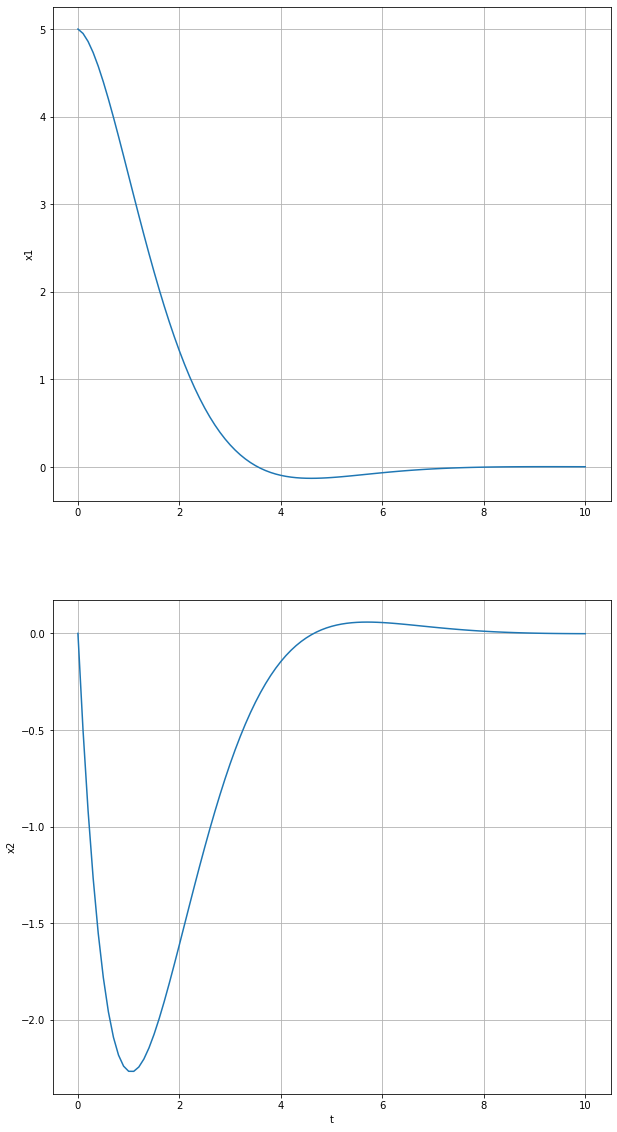

In [25]:

delta_t = dt
n = nx

x_traj = x_list

Nt = np.shape(x_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    x_traj_temp = x_traj[i::n]
    plt.plot(t_plot, x_traj_temp)
    plt.ylabel('x' + str(i + 1))

plt.xlabel('t')
plt.show()

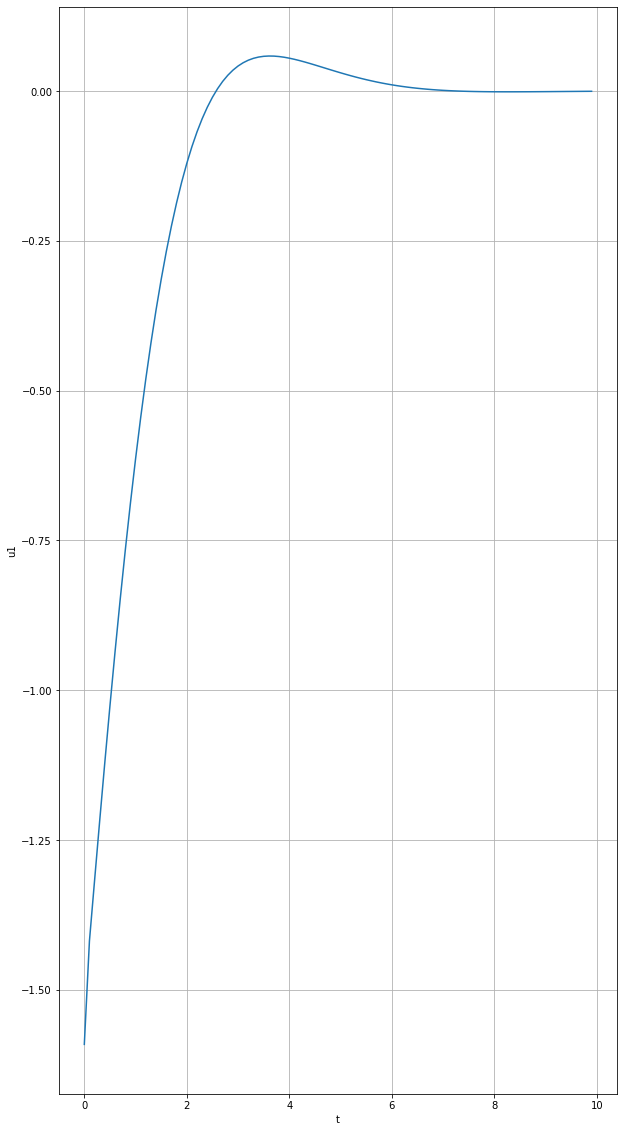

In [26]:
delta_t = dt
n = nu

u_traj = u_list

Nt = np.shape(u_traj[::n])[0]
t_plot = [delta_t * i for i in range(Nt)]

plt.figure(1, figsize=(10, 20))
plt.clf()
for i in range (n):
    plt.subplot( str(n) + str(1) + str(i + 1) )
    plt.grid()
    u_traj_temp = u_traj[i::n]
    plt.plot(t_plot, u_traj_temp)
    plt.ylabel('u' + str(i + 1))

plt.xlabel('t')
plt.show()